In [2]:
import pandas as pd
import requests
from io import StringIO
import os
from dotenv import load_dotenv
import matplotlib.pyplot  as plt
import seaborn as sns



In [6]:
load_dotenv()

True

# Lectura y Preparación

In [3]:

myurl = os.environ["DETALLE_TAREAS_FULL_URL"] + "?" + os.environ["AZURE_DATALAKE_GENAI_TOKEN"]
df = pd.read_parquet(myurl)
df

,FECHA_CIERRE,CODIGO_TAREA,DESCRIPCION_TAREA,INICIO,FIN,DURACION_SEGUNDOS,DURACION
0,2024-07-23,PX999C17,Depuracion del FSC017,2024-07-24 03:42:24,2024-07-24 03:42:25,1.0,00:00:01
1,2024-11-19,PX999C17,Depuracion del FSC017,2024-11-20 02:26:00,2024-11-20 02:26:01,1.0,00:00:01
2,2024-11-18,PX999C17,Depuracion del FSC017,2024-11-19 03:02:58,2024-11-19 03:02:59,1.0,00:00:01
3,2024-07-24,PX999C17,Depuracion del FSC017,2024-07-25 03:36:06,2024-07-25 03:36:08,2.0,00:00:02
4,2024-07-25,PX999C17,Depuracion del FSC017,2024-07-26 03:36:12,2024-07-26 03:36:13,1.0,00:00:01
...,...,...,...,...,...,...,...
12508,2024-11-14,PCSMI001B,Rendicion Batch,2024-11-15 02:38:05,2024-11-15 02:38:06,1.0,00:00:01
12509,2024-11-15,PCSMI001B,Rendicion Batch,2024-11-16 02:36:57,2024-11-16 02:36:58,1.0,00:00:01
12510,2024-11-16,PCSMI001B,Rendicion Batch,2024-11-17 01:40:20,2024-11-17 01:40:21,1.0,00:00:01
12511,2024-11-18,PCSMI001B,Rendicion Batch,2024-11-19 03:02:57,2024-11-19 03:02:58,1.0,00:00:01


In [4]:
df["FECHA_CIERRE"]=pd.to_datetime(df.FECHA_CIERRE,yearfirst=True,dayfirst=True)
df["DIA_SEMANA"]=df.FECHA_CIERRE.dt.day_of_week+1
df["DIA_SEMANA_NOM"]=df.FECHA_CIERRE.dt.day_name()
df["DIA_MES"]=df.FECHA_CIERRE.dt.days_in_month
df

,FECHA_CIERRE,CODIGO_TAREA,DESCRIPCION_TAREA,INICIO,FIN,DURACION_SEGUNDOS,DURACION,DIA_SEMANA,DIA_SEMANA_NOM,DIA_MES
0,2024-07-23,PX999C17,Depuracion del FSC017,2024-07-24 03:42:24,2024-07-24 03:42:25,1.0,00:00:01,2,Tuesday,31
1,2024-11-19,PX999C17,Depuracion del FSC017,2024-11-20 02:26:00,2024-11-20 02:26:01,1.0,00:00:01,2,Tuesday,30
2,2024-11-18,PX999C17,Depuracion del FSC017,2024-11-19 03:02:58,2024-11-19 03:02:59,1.0,00:00:01,1,Monday,30
3,2024-07-24,PX999C17,Depuracion del FSC017,2024-07-25 03:36:06,2024-07-25 03:36:08,2.0,00:00:02,3,Wednesday,31
4,2024-07-25,PX999C17,Depuracion del FSC017,2024-07-26 03:36:12,2024-07-26 03:36:13,1.0,00:00:01,4,Thursday,31
...,...,...,...,...,...,...,...,...,...,...
12508,2024-11-14,PCSMI001B,Rendicion Batch,2024-11-15 02:38:05,2024-11-15 02:38:06,1.0,00:00:01,4,Thursday,30
12509,2024-11-15,PCSMI001B,Rendicion Batch,2024-11-16 02:36:57,2024-11-16 02:36:58,1.0,00:00:01,5,Friday,30
12510,2024-11-16,PCSMI001B,Rendicion Batch,2024-11-17 01:40:20,2024-11-17 01:40:21,1.0,00:00:01,6,Saturday,30
12511,2024-11-18,PCSMI001B,Rendicion Batch,2024-11-19 03:02:57,2024-11-19 03:02:58,1.0,00:00:01,1,Monday,30


In [5]:
df["ID_TAREA"]=df.CODIGO_TAREA+"-"+df.DESCRIPCION_TAREA
df["DURACION_MIN"]=(df.DURACION_SEGUNDOS/60).round(0)
df["DURACION_HR"]=df.DURACION_SEGUNDOS/60/60
df["PAUSA"]=df.CODIGO_TAREA=="PAUSA"

In [6]:
df["PAUSA"].value_counts()


PAUSA
False    12015
True       498
Name: count, dtype: int64

# Análisis

## Duración total

### Distribución

In [7]:
df.groupby(["FECHA_CIERRE"], as_index=False,)["DURACION_MIN"].agg(["max","min","mean","median","sum"]	).sort_values("sum",ascending=False)

,FECHA_CIERRE,max,min,mean,median,sum
7,2024-07-31,111.0,0.0,4.762500,1.0,762.0
3,2024-07-26,203.0,0.0,5.503817,0.0,721.0
12,2024-08-06,180.0,0.0,4.559055,0.0,579.0
63,2024-10-07,106.0,0.0,4.285714,0.0,540.0
86,2024-11-05,110.0,0.0,4.095238,0.0,516.0
...,...,...,...,...,...,...
82,2024-10-30,39.0,0.0,2.484127,0.0,313.0
56,2024-09-28,37.0,0.0,2.440945,0.0,310.0
90,2024-11-09,29.0,0.0,2.373016,0.0,299.0
94,2024-11-15,31.0,0.0,2.365079,0.0,298.0


array([[<Axes: title={'center': 'sum'}>]], dtype=object)

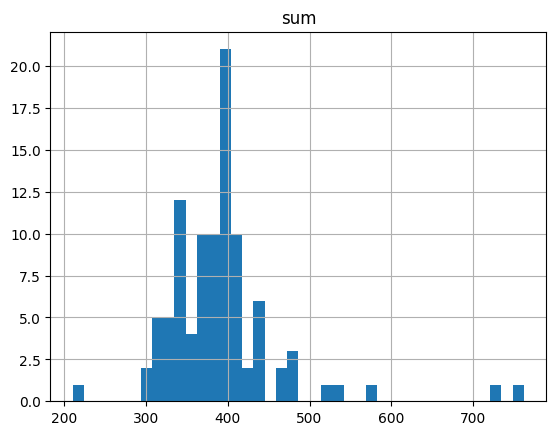

In [106]:
df.groupby(["FECHA_CIERRE"], )["DURACION_MIN"].agg(["sum"]	).hist(bins=40)

In [103]:
df.groupby(["FECHA_CIERRE"], )["DURACION_MIN"].agg(["sum"]	).describe()

,sum
count,98.000000
mean,391.938776
std,72.593177
min,211.000000
25%,346.000000
50%,390.000000
75%,407.250000
max,762.000000


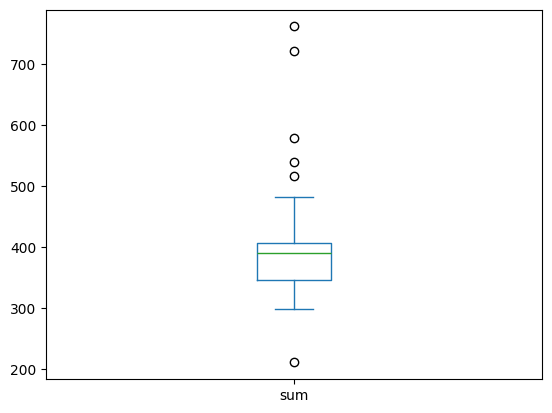

In [73]:
df.groupby(["FECHA_CIERRE"], )["DURACION_MIN"].agg(["sum"]	).plot.box()

Conclusion. Distribución de cola derecha con valores extremos (anomalias) por encima de 500

## Pausas

In [10]:
df_sum=df.groupby("FECHA_CIERRE", as_index=True)["DURACION_MIN"].agg(["max","sum"])
df_sum.rename(columns={"max":"TAREA_MAX","sum":"TOTAL"}, inplace=True)
df_sum_pausas=df[df["PAUSA"]].groupby("FECHA_CIERRE", as_index=False)["DURACION_MIN"].sum()
df_sum_pausas.set_index("FECHA_CIERRE", inplace=True)
df_sum_pausas.rename(columns={"DURACION_MIN":"DURACION_PAUSAS"},inplace=True)
df_sum=df_sum.join(df_sum_pausas,)
df_sum["SIN_PAUSA"]=df_sum.TOTAL - df_sum.DURACION_PAUSAS
df_sum

,TAREA_MAX,TOTAL,DURACION_PAUSAS,SIN_PAUSA
FECHA_CIERRE,,,,
2024-07-23,32.0,211.0,5.0,206.0
2024-07-24,67.0,436.0,74.0,362.0
2024-07-25,65.0,445.0,80.0,365.0
2024-07-26,203.0,721.0,77.0,644.0
2024-07-27,46.0,408.0,63.0,345.0
...,...,...,...,...
2024-11-14,41.0,382.0,78.0,304.0
2024-11-15,31.0,298.0,29.0,269.0
2024-11-16,38.0,337.0,86.0,251.0


<Axes: xlabel='FECHA_CIERRE'>

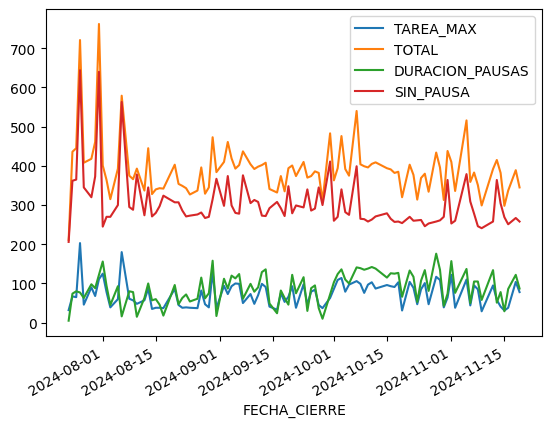

In [11]:
df_sum.plot(subplots=False)

Los datos antes del mes 9 tienen picos y n estaban asociados a pausas

<Axes: xlabel='FECHA_CIERRE'>

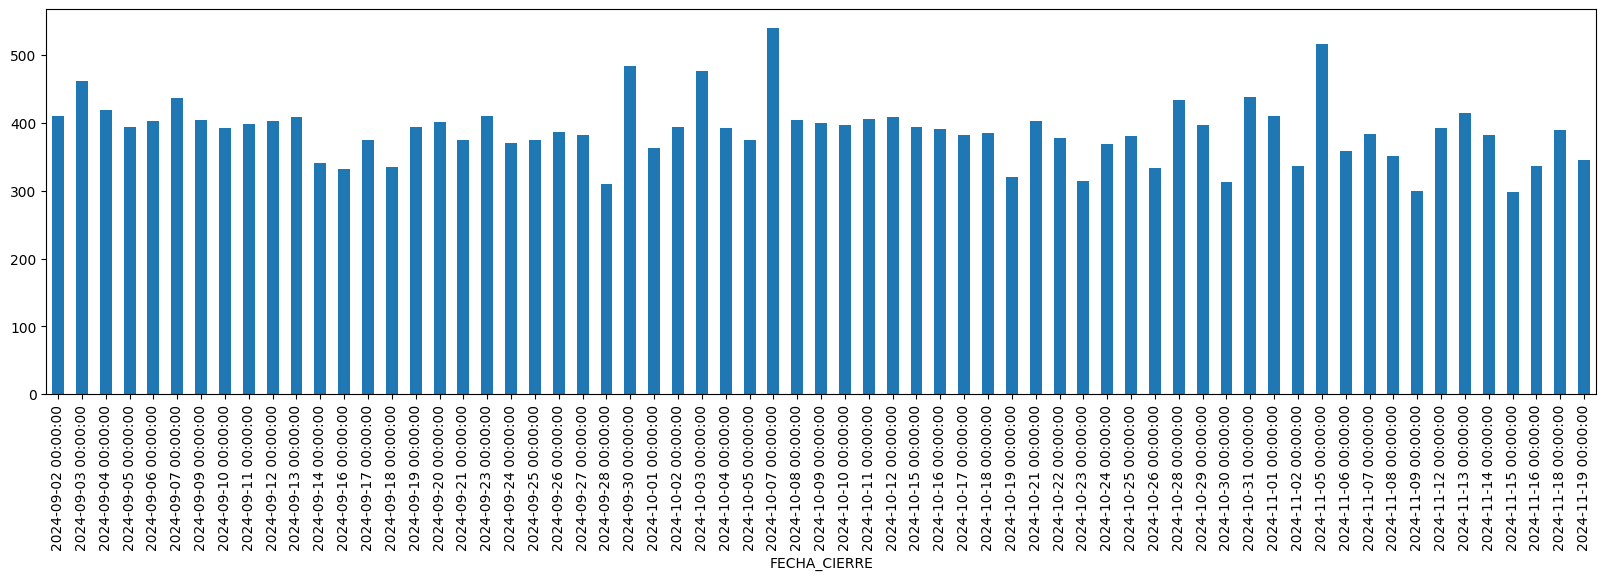

In [23]:
plt.figure(figsize=(20,5))
df_sum.query("index >= '2024-09-01' ")["TOTAL"].plot.bar()


<Axes: xlabel='FECHA_CIERRE'>

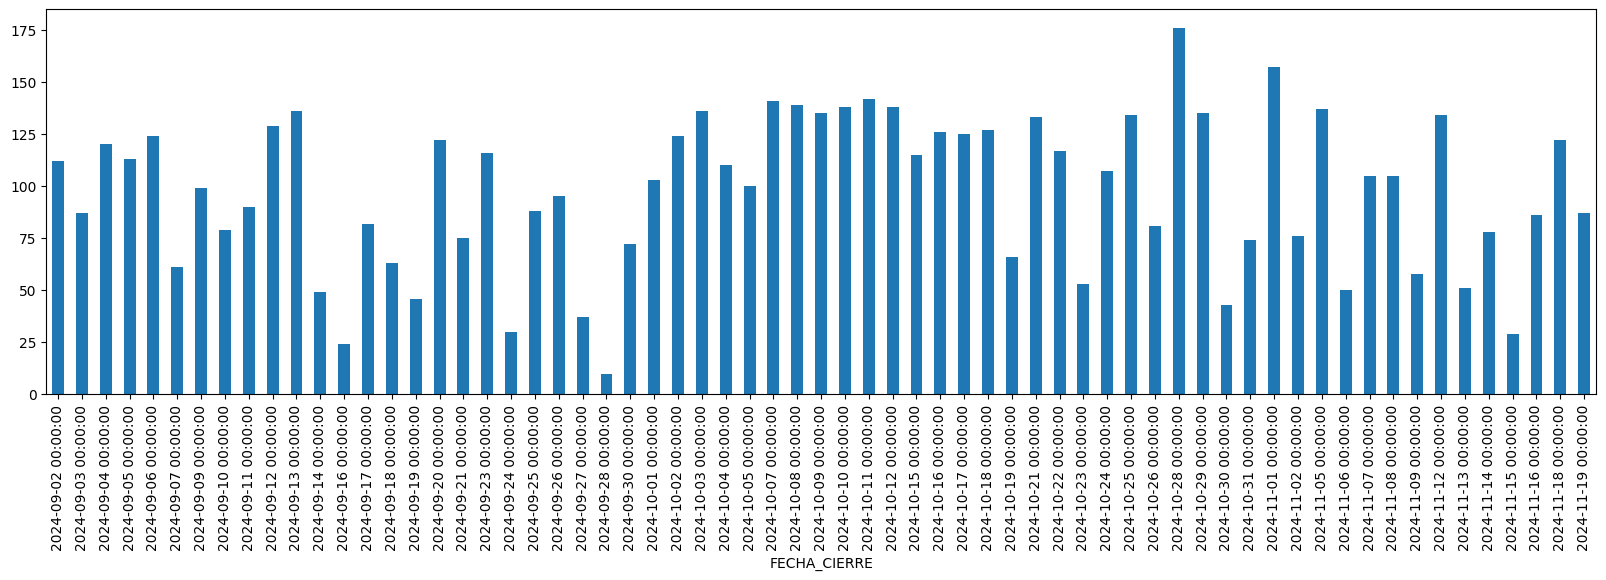

In [25]:
plt.figure(figsize=(20,5))
df_sum_parcial=df_sum.query("index >= '2024-09-01' ")
df_sum_parcial["DURACION_PAUSAS"].plot.bar()


<Axes: >

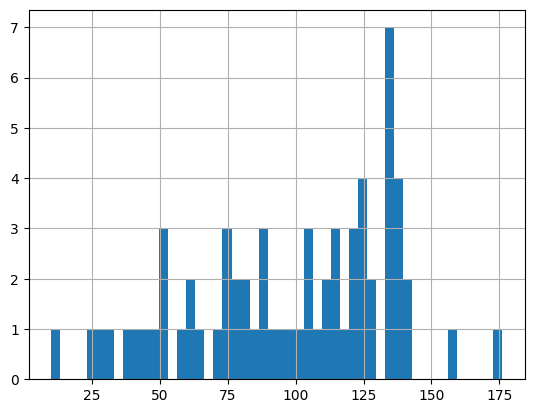

In [ ]:
df_sum_parcial["DURACION_PAUSAS"].hist(bins=50)

<Axes: xlabel='FECHA_CIERRE'>

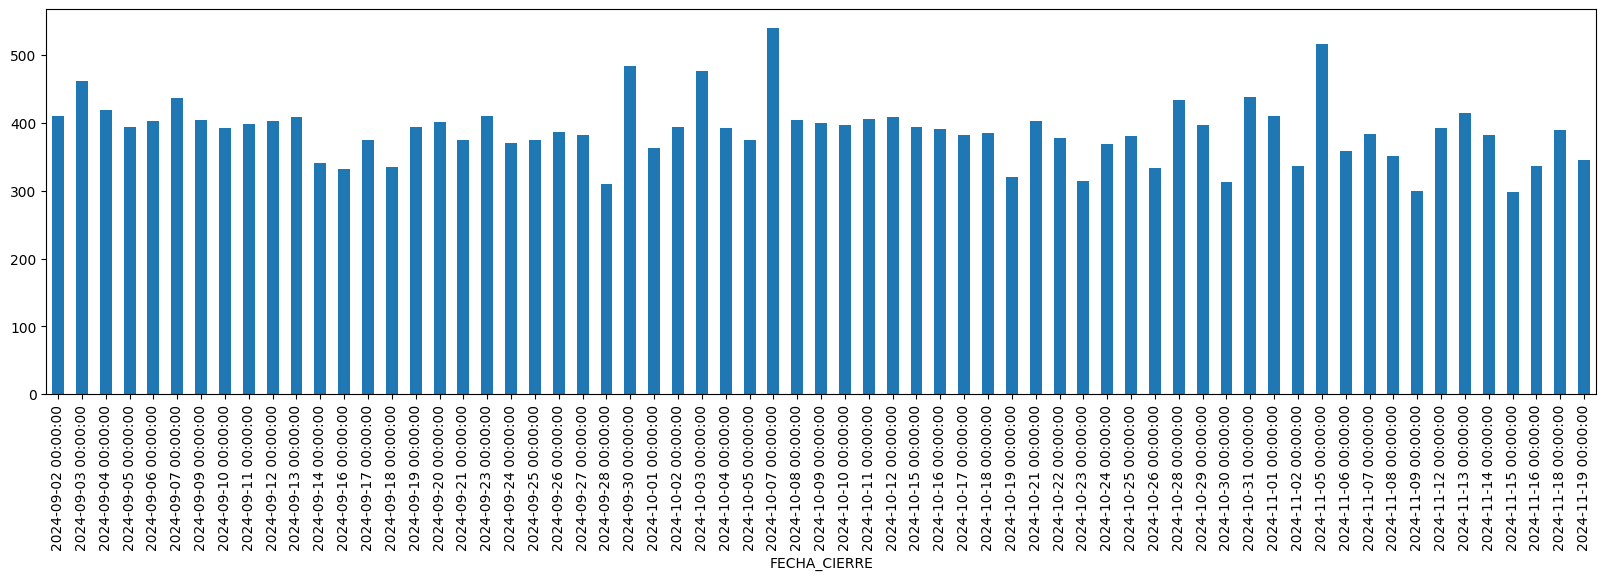

In [ ]:
plt.figure(figsize=(20,5))
df_sum.query("index >= '2024-09-01' ")["TOTAL"].plot.bar()


In [32]:
df_sum_parcial["DURACION_PAUSAS"]

FECHA_CIERRE
2024-09-02    112.0
2024-09-03     87.0
2024-09-04    120.0
2024-09-05    113.0
2024-09-06    124.0
              ...  
2024-11-14     78.0
2024-11-15     29.0
2024-11-16     86.0
2024-11-18    122.0
2024-11-19     87.0
Name: DURACION_PAUSAS, Length: 65, dtype: float64

array([<Axes: xlabel='FECHA'>, <Axes: xlabel='FECHA'>,
       <Axes: xlabel='FECHA'>], dtype=object)

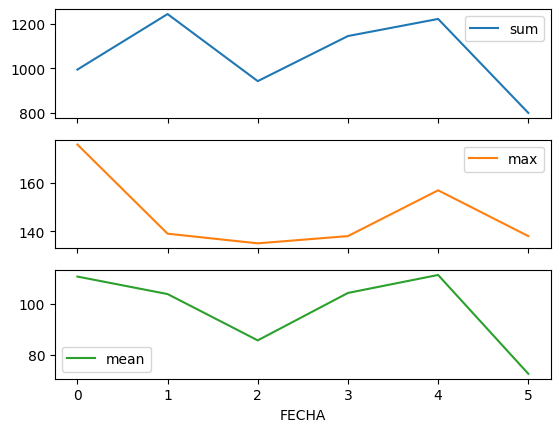

In [48]:
df_sum_parcial.groupby(df_sum_parcial["FECHA"].dt.day_of_week)["DURACION_PAUSAS"].agg(["sum","max","mean"]).plot(subplots=True)

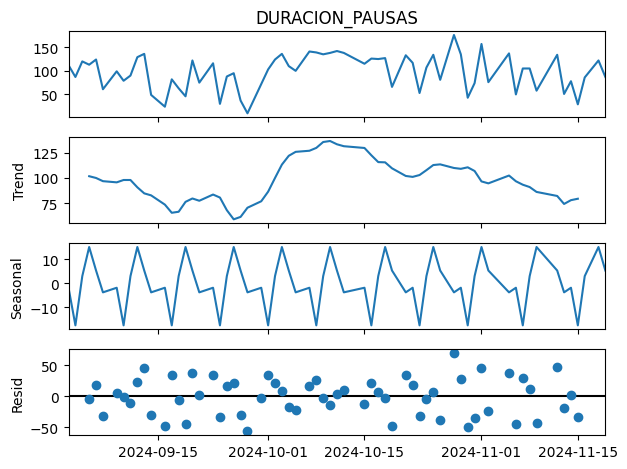

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(df_sum_parcial["DURACION_PAUSAS"], model="additive", period=6)

decompose_result_mult.plot();

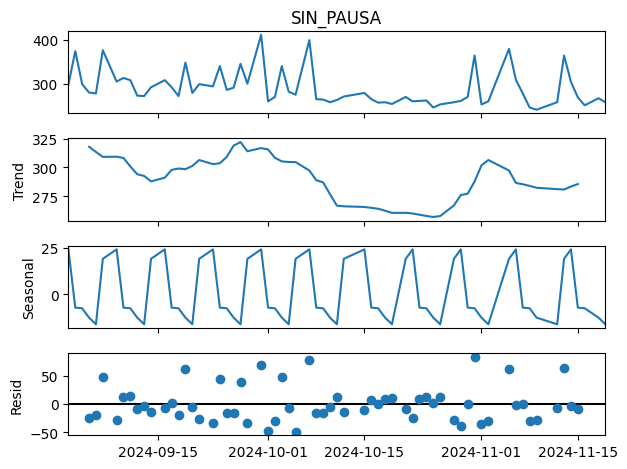

In [54]:
decompose_result_mult = seasonal_decompose(df_sum_parcial["SIN_PAUSA"], model="additive", period=6)

decompose_result_mult.plot();

## Tareas representativas

### Top tareas minutos totales

In [57]:
df_tareas_agg=df.query("FECHA_CIERRE >= '2024-09-10'").groupby(["ID_TAREA"], as_index=True,)["DURACION_MIN"].agg(["max","min","mean","median","count","sum"]	).sort_values("sum",ascending=False)
df_parcial = df.query("FECHA_CIERRE >= '2024-09-10'")

In [72]:
df_agg_top=df_tareas_agg.sort_values("sum",ascending=False).head(10)
df_agg_top


,max,min,mean,median,count,sum
ID_TAREA,,,,,,
PAUSA-Pausa cargar interfaz SIAD new,122.0,1.0,67.741379,81.5,58,3929.0
PBCGD017-GENERACION FSH012 NUEVO,42.0,27.0,33.448276,32.0,58,1940.0
PSNG9122-Genera Datos Tablon,21.0,17.0,18.810345,19.0,58,1091.0
PNU00217-Pasaje Resultados M/E a M/N Ac,32.0,8.0,17.793103,17.0,58,1032.0
PAUSA-PAUSA para cargar pagos,91.0,0.0,17.741379,12.0,58,1029.0
PJBWM077-Carga datos para tablas ICS,22.0,14.0,17.396552,17.5,58,1009.0
PP017-Depurador,30.0,12.0,16.431034,16.0,58,953.0
PNU00002-Devengamiento a Plazo,22.0,11.0,15.120690,16.0,58,877.0
PCC00003-Devengamiento Vista,23.0,11.0,14.293103,14.0,58,829.0


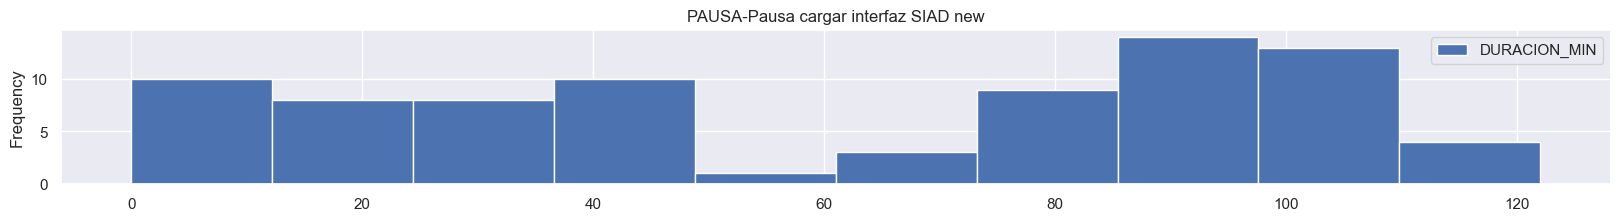

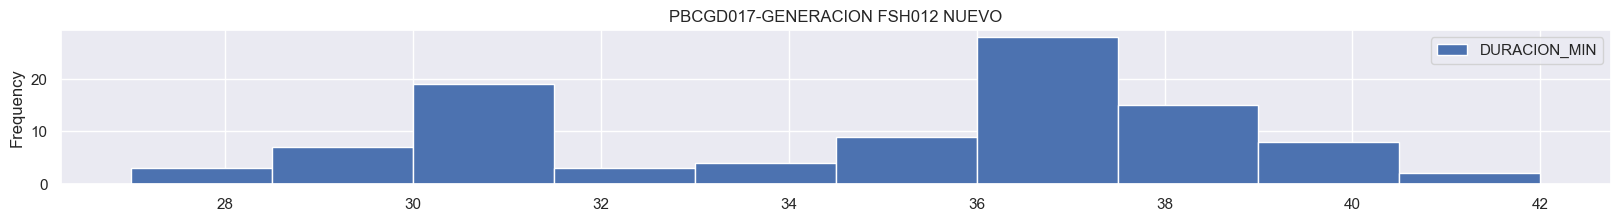

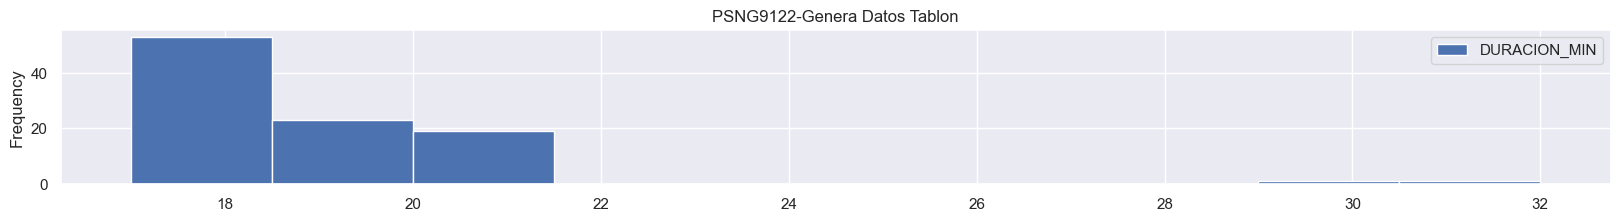

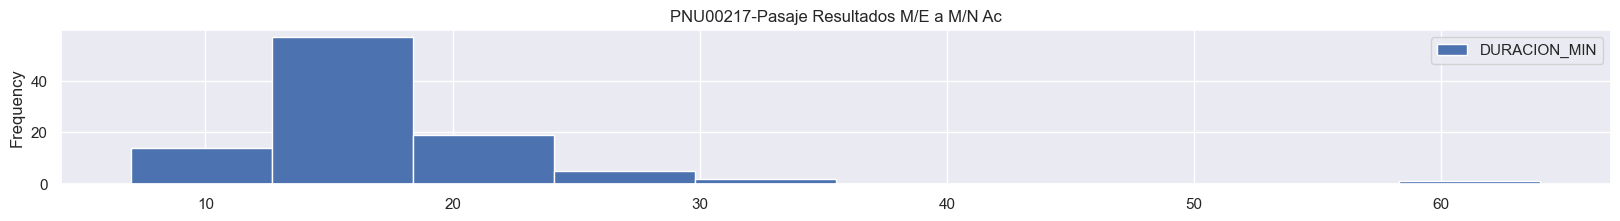

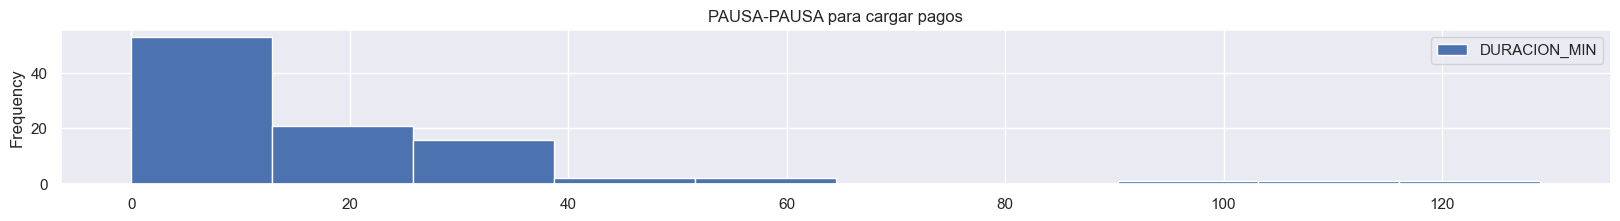

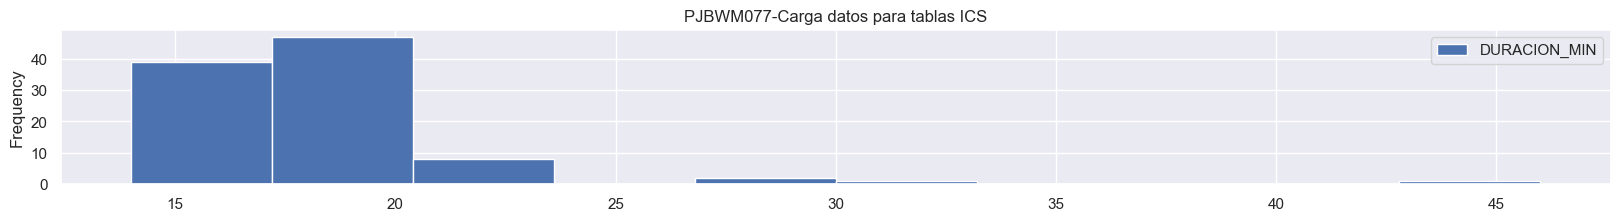

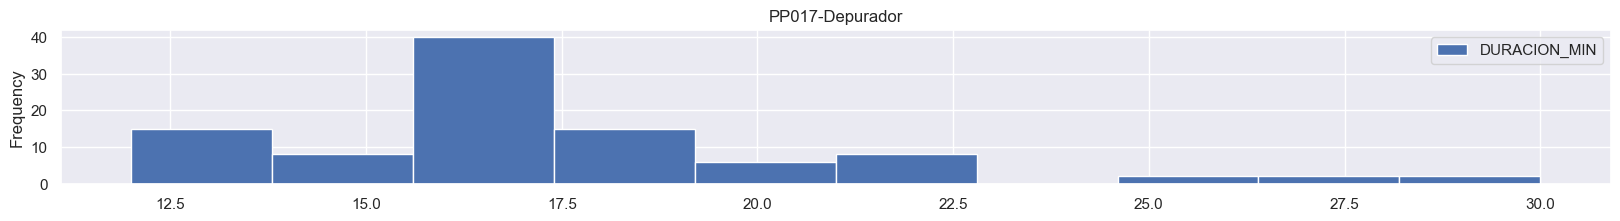

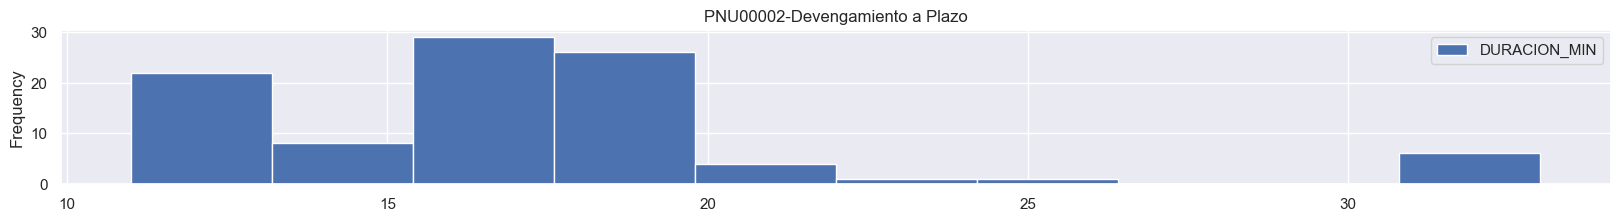

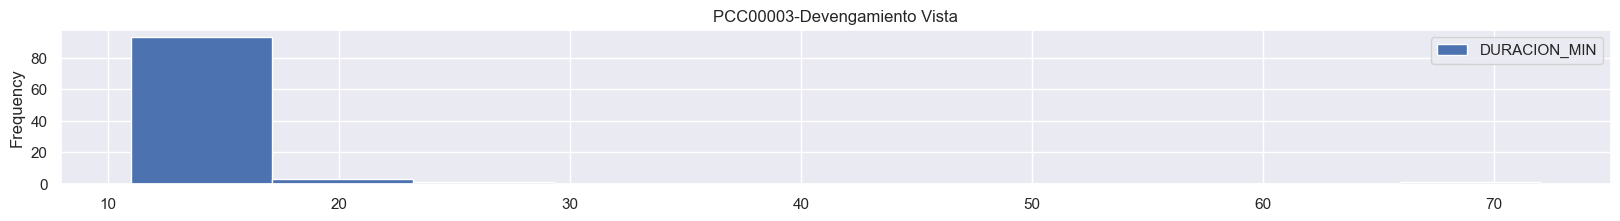

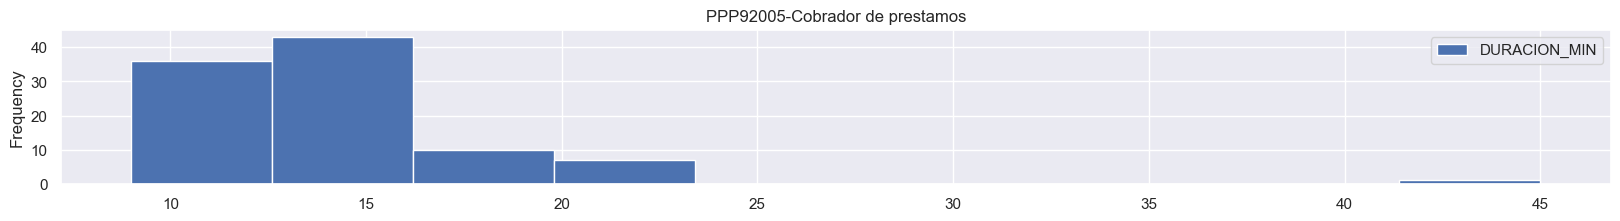

In [89]:
lst_top=df_agg_top.index.to_list()
sns.set_theme(rc={'figure.figsize':(20,2)})
#sns.relplot(
#    data=df_parcial[df_parcial["ID_TAREA"].isin(lst_top)], kind="line",
#    y="DURACION_MIN", x="FECHA_CIERRE", 
#    col="ID_TAREA", col_wrap=2,
#    height=3, aspect=.9, linewidth=2.5,
#)
for tarea in lst_top:
    df[df["ID_TAREA"]==tarea][["ID_TAREA","DURACION_MIN"]].plot.hist(bins=10,by="ID_TAREA")
   

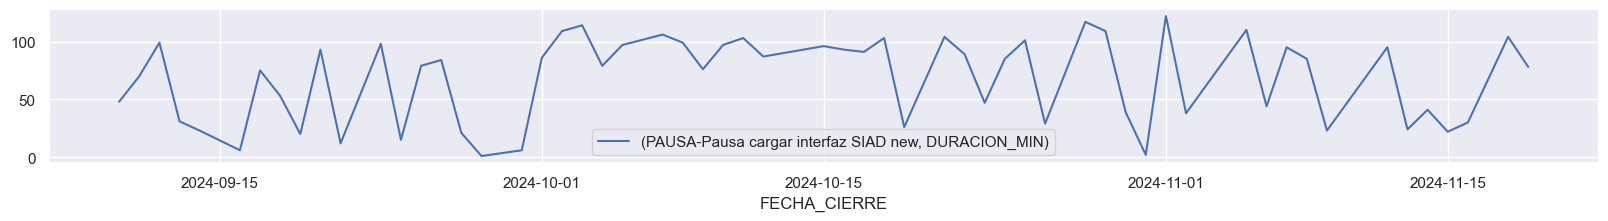

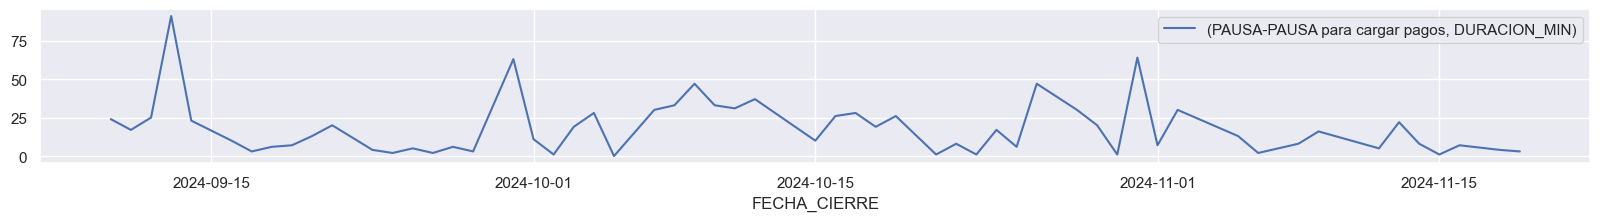

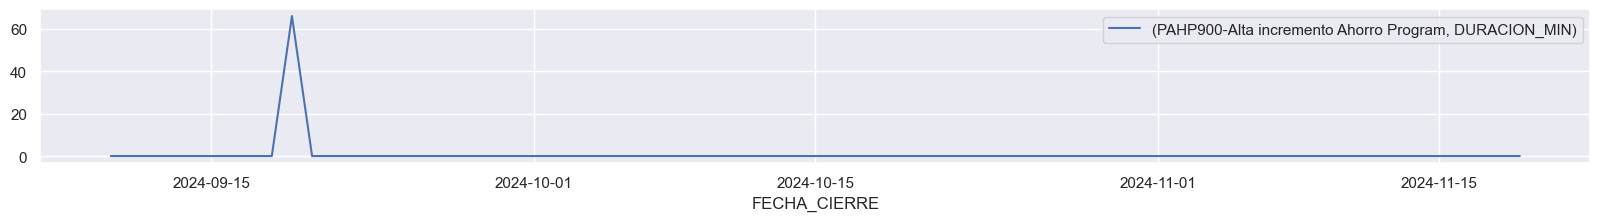

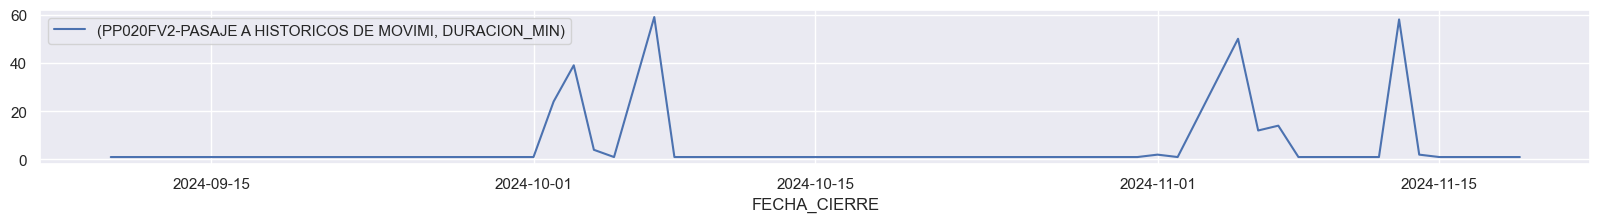

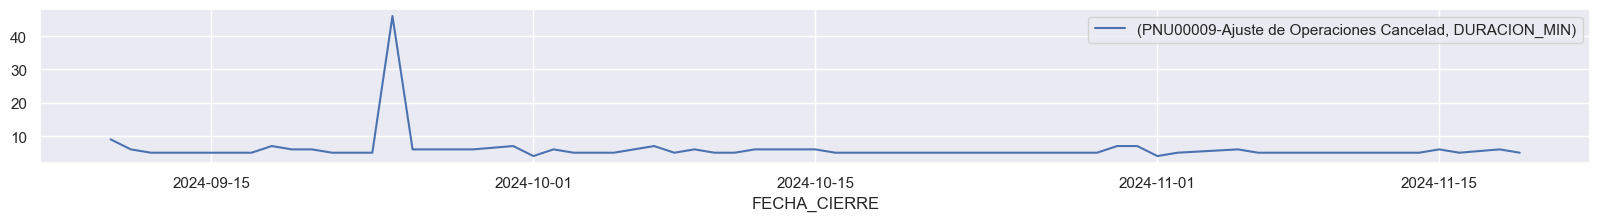

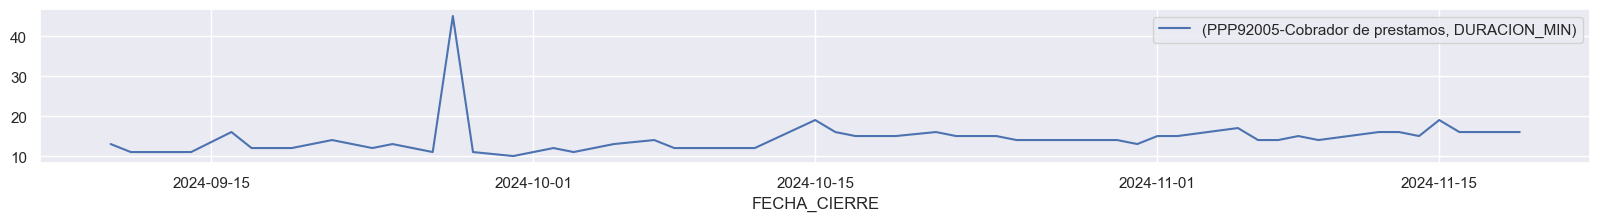

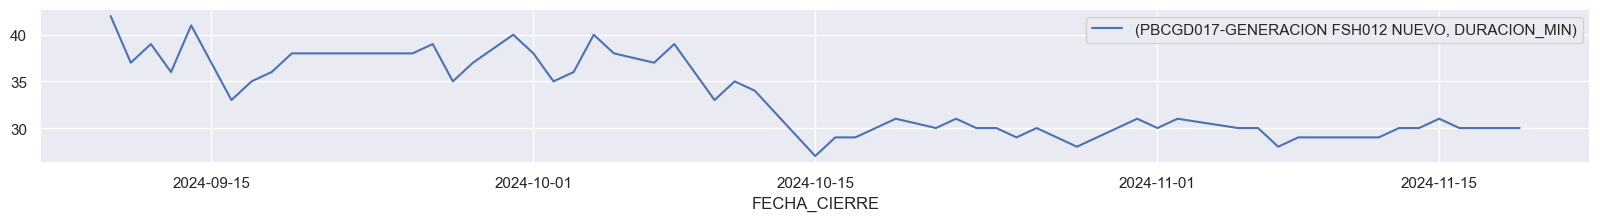

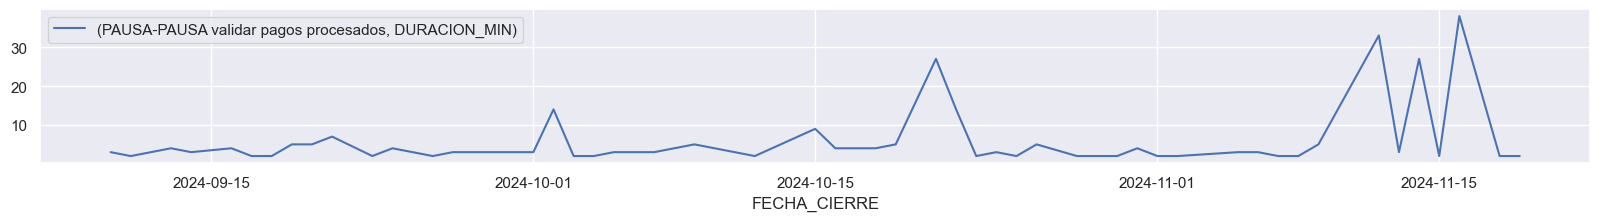

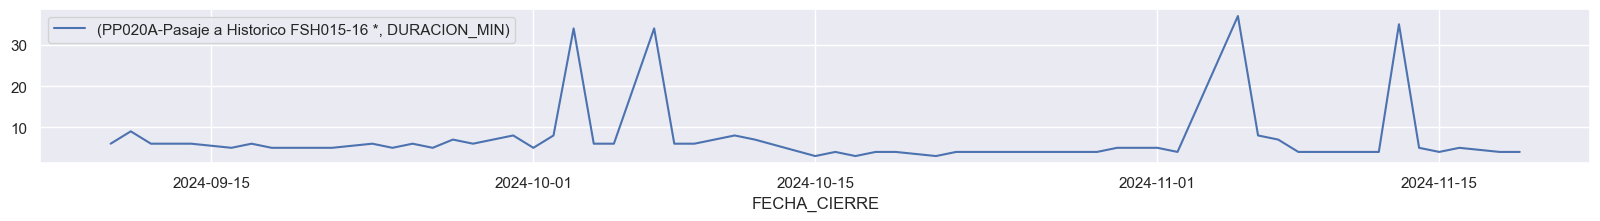

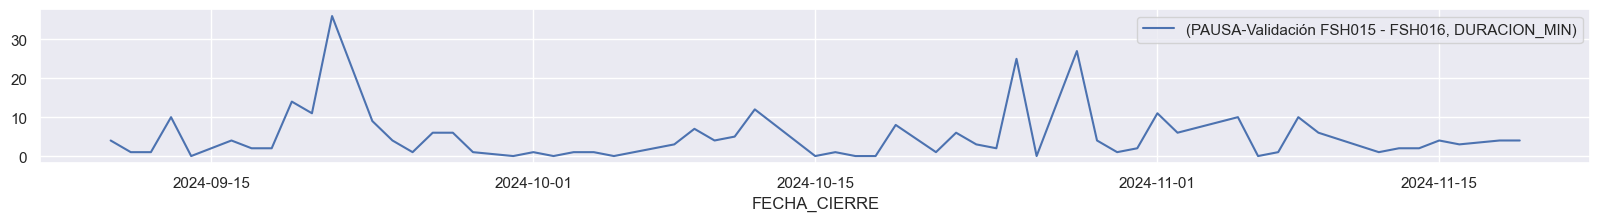

In [91]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["ID_TAREA"]==tarea].groupby("FECHA_CIERRE")[["ID_TAREA","DURACION_MIN"]].max().plot(by="ID_TAREA")
    

### Ordenados por máximo

In [74]:
df_tareas_agg.sort_values("max",ascending=False).head(10)

,max,min,mean,median,count,sum
ID_TAREA,,,,,,
PAUSA-Pausa cargar interfaz SIAD new,122.0,1.0,67.741379,81.5,58,3929.0
PAUSA-PAUSA para cargar pagos,91.0,0.0,17.741379,12.0,58,1029.0
PAHP900-Alta incremento Ahorro Program,66.0,0.0,1.137931,0.0,58,66.0
PP020FV2-PASAJE A HISTORICOS DE MOVIMI,59.0,1.0,5.379310,1.0,58,312.0
PNU00009-Ajuste de Operaciones Cancelad,46.0,4.0,6.155172,5.0,58,357.0
PPP92005-Cobrador de prestamos,45.0,10.0,14.224138,14.0,58,825.0
PBCGD017-GENERACION FSH012 NUEVO,42.0,27.0,33.448276,32.0,58,1940.0
PAUSA-PAUSA validar pagos procesados,38.0,2.0,5.517241,3.0,58,320.0
PP020A-Pasaje a Historico FSH015-16 *,37.0,3.0,7.293103,5.0,58,423.0


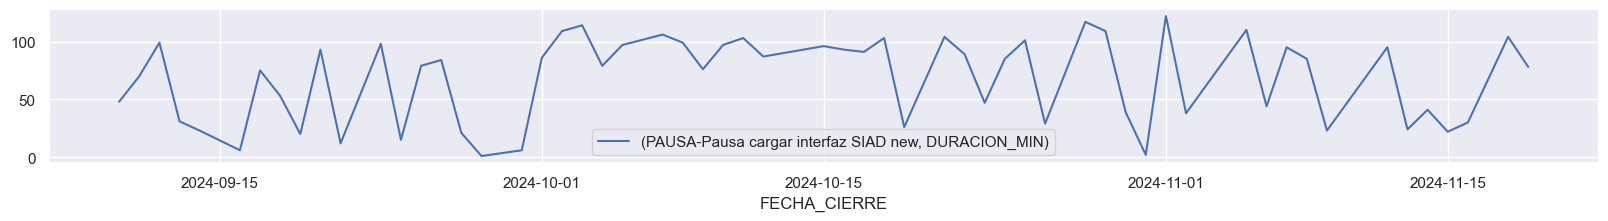

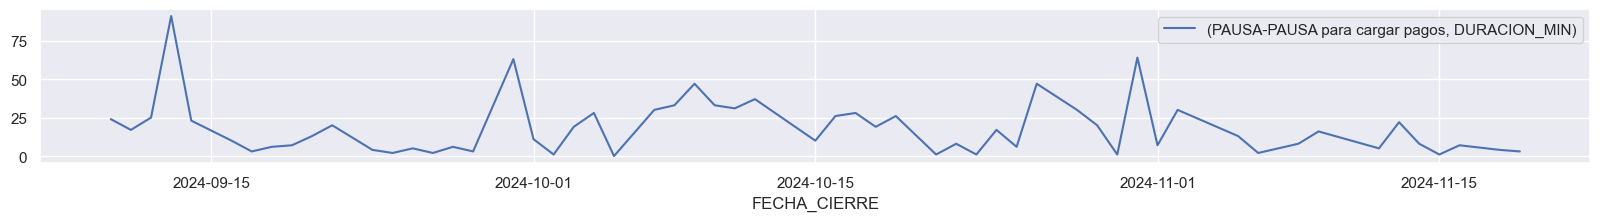

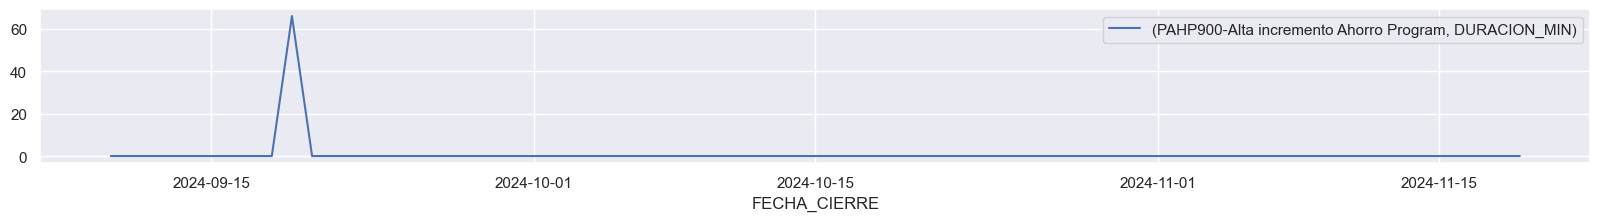

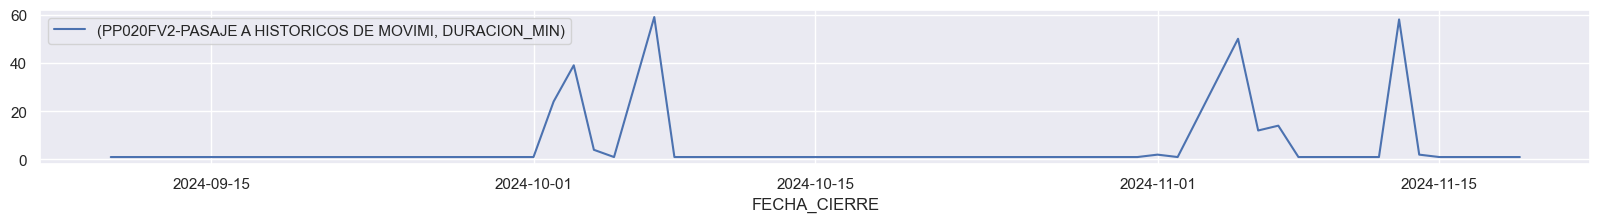

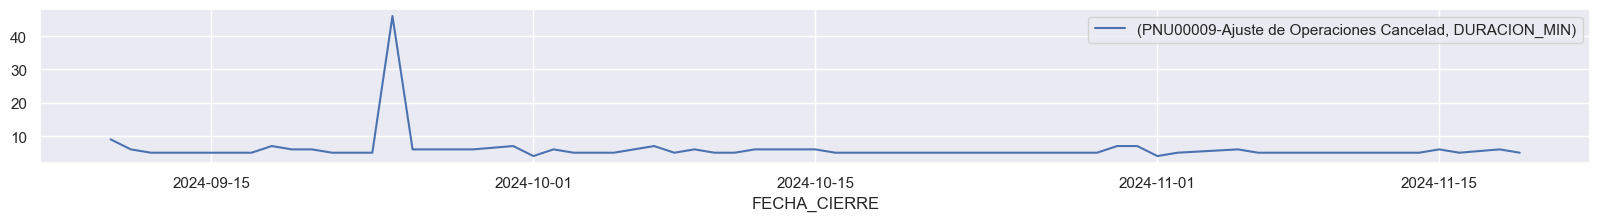

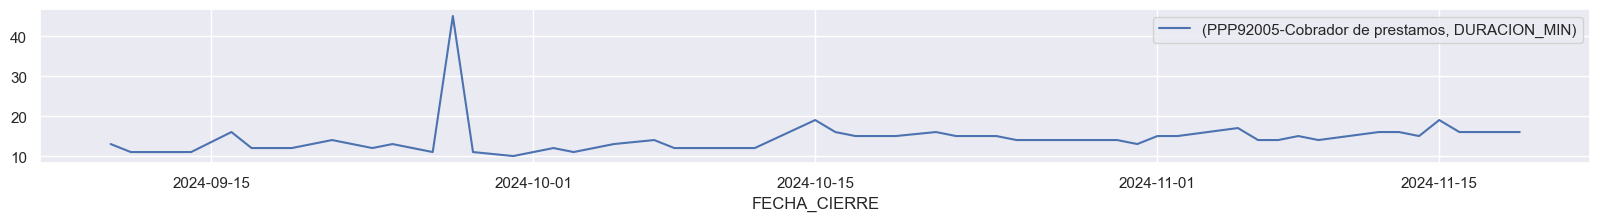

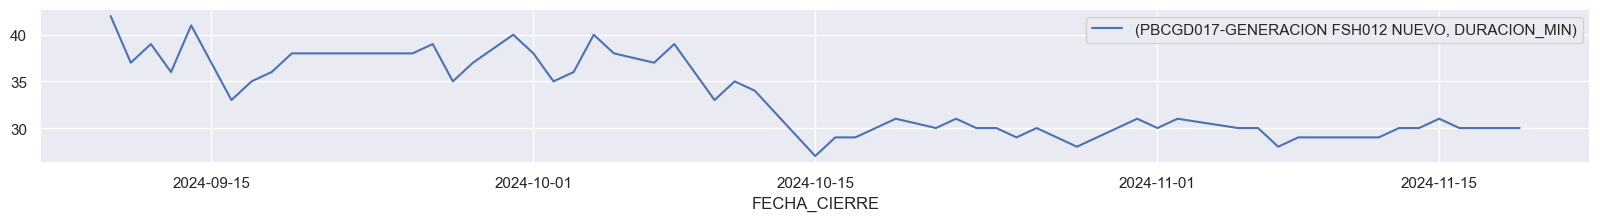

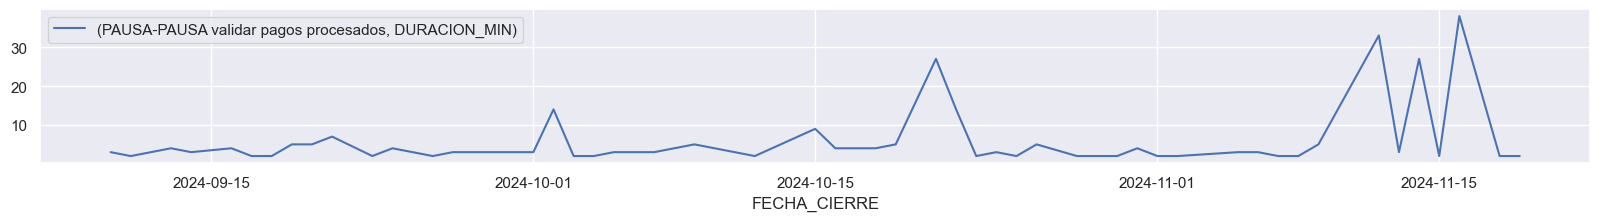

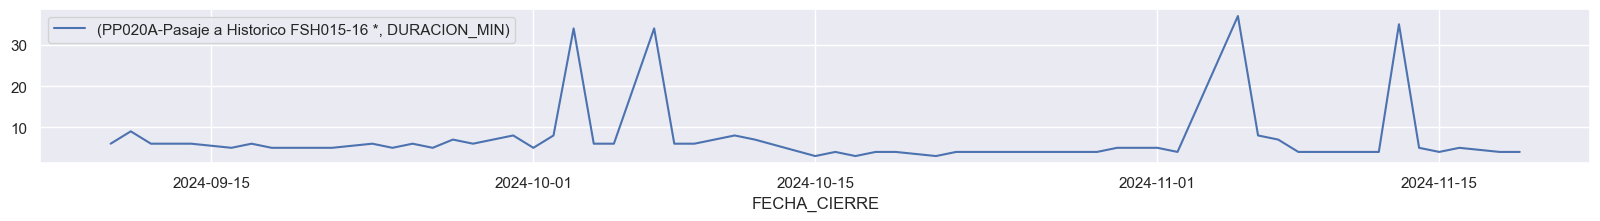

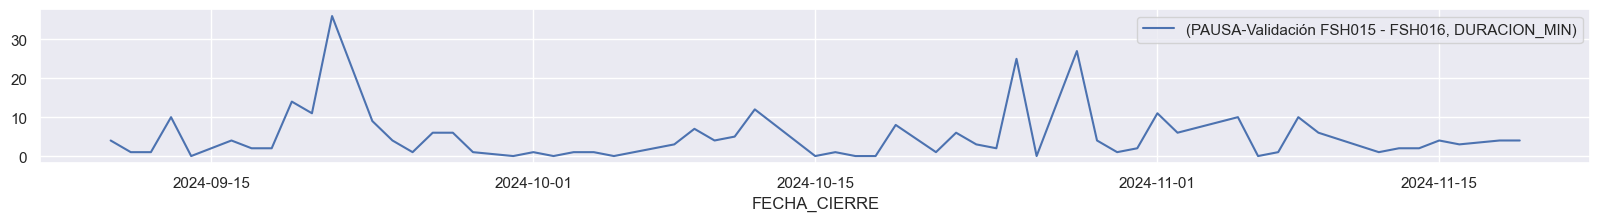

In [90]:

for tarea in df_tareas_agg.sort_values("max",ascending=False).head(10).index:
     df_parcial[df_parcial["ID_TAREA"]==tarea].groupby("FECHA_CIERRE")[["ID_TAREA","DURACION_MIN"]].max().plot(by="ID_TAREA")
    

In [49]:
df_sum["FECHA"]=df_sum.index
df_sum["FECHA"]

FECHA_CIERRE
2024-07-23   2024-07-23
2024-07-24   2024-07-24
2024-07-25   2024-07-25
2024-07-26   2024-07-26
2024-07-27   2024-07-27
                ...    
2024-11-14   2024-11-14
2024-11-15   2024-11-15
2024-11-16   2024-11-16
2024-11-18   2024-11-18
2024-11-19   2024-11-19
Name: FECHA, Length: 98, dtype: datetime64[ns]